# Intro to Art Neural Network with Keras

In [1]:
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

2023-10-01 09:27:11.161723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Perceptrons

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

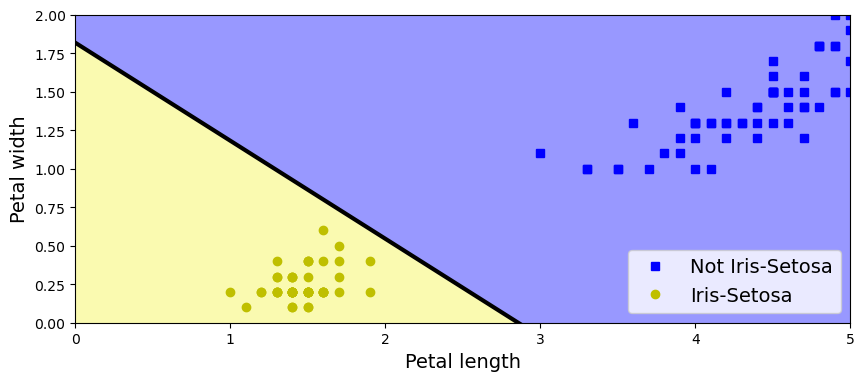

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

#### Activation Functions

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

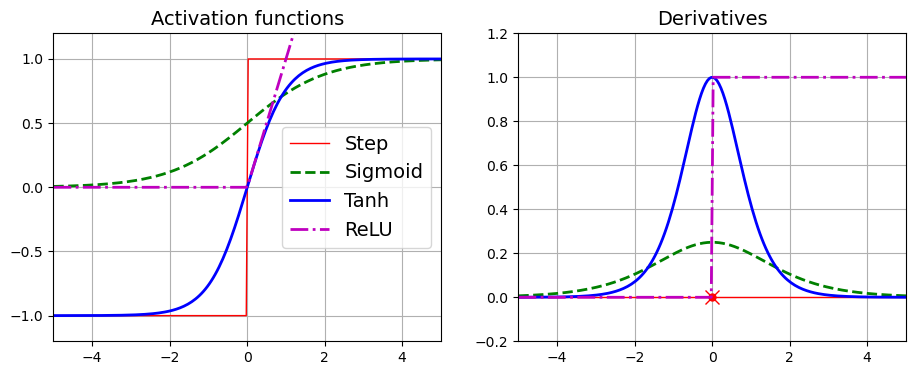

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

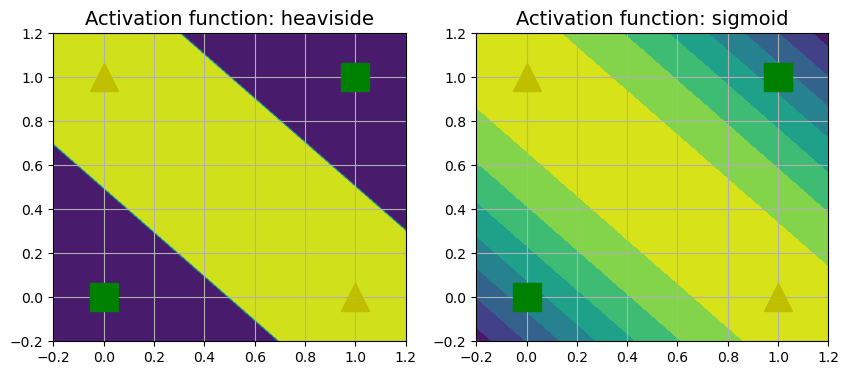

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

### Building an Image Classifier 

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
tf.__version__

'2.10.0'

In [11]:
keras.__version__

'2.10.0'

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [13]:
X_train_full.shape

(60000, 28, 28)

In [14]:
X_train_full.dtype

dtype('uint8')

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

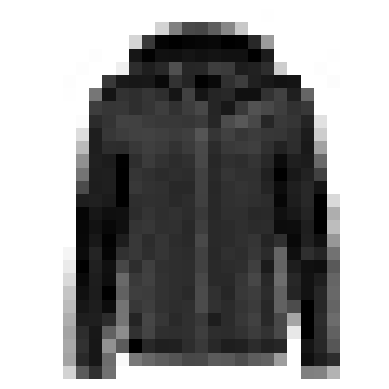

In [16]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [19]:
class_names[y_train[0]]

'Coat'

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

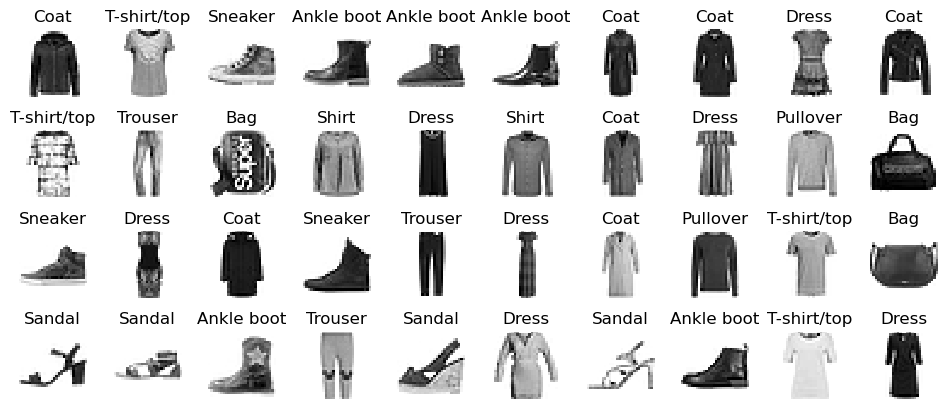

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Creating the model using the Sequential API

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2023-10-01 09:34:23.739433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.layers

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [28]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [30]:
model.get_layer(hidden1.name) is hidden1

True

In [31]:
weights, biases = hidden1.get_weights()

In [32]:
weights

array([[ 0.07375523, -0.05022619,  0.05489855, ...,  0.01380711,
        -0.02102689,  0.05976419],
       [ 0.06856909,  0.06485102, -0.02928199, ..., -0.05014743,
         0.0554534 ,  0.02959807],
       [ 0.05265477, -0.01427278, -0.02203932, ..., -0.03543069,
         0.0707974 ,  0.02619736],
       ...,
       [ 0.07358313, -0.0533613 , -0.0311434 , ..., -0.03419654,
        -0.00316124,  0.02305336],
       [-0.05512513,  0.07136637, -0.03835995, ...,  0.02307693,
        -0.07211389,  0.04111975],
       [-0.02678129, -0.02699226,  0.01743292, ...,  0.03787025,
         0.03003798, -0.02033095]], dtype=float32)

In [33]:
weights.shape

(784, 300)

In [34]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
biases.shape

(300,)

In [36]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [37]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7307 - accuracy: 0.7593 - val_loss: 0.5237 - val_accuracy: 0.8218
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4887 - accuracy: 0.8290 - val_loss: 0.4401 - val_accuracy: 0.8514
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4431 - accuracy: 0.8449 - val_loss: 0.5542 - val_accuracy: 0.7924
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4161 - accuracy: 0.8557 - val_loss: 0.3966 - val_accuracy: 0.8678
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3973 - accuracy: 0.8614 - val_loss: 0.3815 - val_accuracy: 0.8664
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3782 - accuracy: 0.8669 - val_loss: 0.3780 - val_accuracy: 0.8724
Epoch 7/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3657 - accuracy: 0.8712 - val_loss: 0.3709 - val_accuracy:

#### Compiling the model

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [39]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2230 - accuracy: 0.9195 - val_loss: 0.2930 - val_accuracy: 0.8942
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2205 - accuracy: 0.9211 - val_loss: 0.2882 - val_accuracy: 0.8972
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2161 - accuracy: 0.9226 - val_loss: 0.3726 - val_accuracy: 0.8656
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2132 - accuracy: 0.9239 - val_loss: 0.2959 - val_accuracy: 0.8940
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2116 - accuracy: 0.9239 - val_loss: 0.2850 - val_accuracy: 0.8956
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2062 - accuracy: 0.9262 - val_loss: 0.2942 - val_accuracy: 0.8946
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2029 - accuracy: 0.9286 - val_loss: 0.2968 - val_accuracy:

In [40]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [41]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

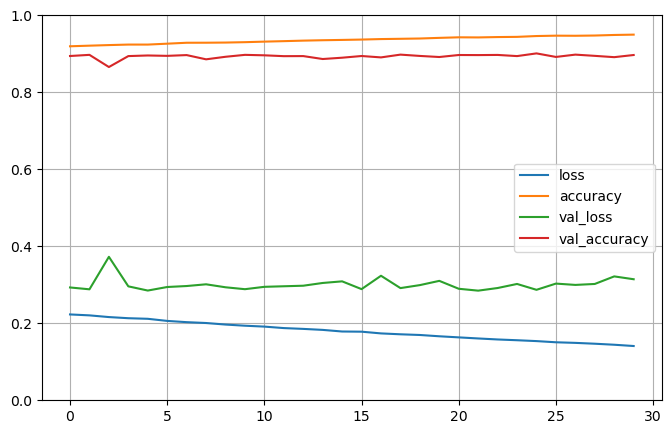

In [43]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [44]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3483 - accuracy: 0.8876


[0.34831854701042175, 0.8876000046730042]

#### Using the model to make predictions

In [45]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 149ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [46]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 25ms/step


array([9, 2, 1])

In [47]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [48]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

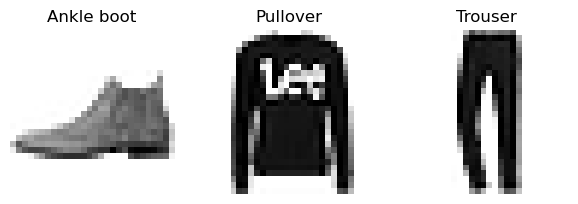

In [49]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Building a Regression MLP Using the Sequential API 

In [50]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.3001 - val_loss: 0.8917
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7390 - val_loss: 0.7396
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6315 - val_loss: 0.6665
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5983 - val_loss: 0.5601
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5732 - val_loss: 0.5327
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5510 - val_loss: 0.5335
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5330 - val_loss: 0.5284
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5177 - val_loss: 0.4794
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5030 - val_loss: 0.4672
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4907 - val_loss: 0.4672

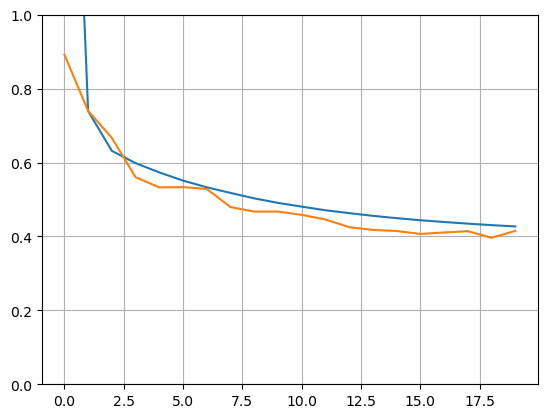

In [53]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [54]:
y_pred

array([[0.5546879],
       [1.660429 ],
       [3.3276448]], dtype=float32)

### Building Complex Models Using the Functional API

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [58]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6775 - val_loss: 0.8641
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7344 - val_loss: 0.6605
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6572 - val_loss: 0.5962
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6047 - val_loss: 0.5608
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5651 - val_loss: 0.5345
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5328 - val_loss: 0.4874
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5080 - val_loss: 0.4677
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4891 - val_loss: 0.4842
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4728 - val_loss: 0.4398
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4607 - val_loss: 0.4226

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [61]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1909 - val_loss: 1.3914
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8038 - val_loss: 0.6988
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6849 - val_loss: 0.6318
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6317 - val_loss: 0.5806
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5949 - val_loss: 0.5485
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5653 - val_loss: 0.5223
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5413 - val_loss: 0.5047
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5209 - val_loss: 0.4816
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5036 - val_loss: 0.4627
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4895 - val_loss: 0.4509

#### Regularizing

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [64]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [65]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1711 - main_output_loss: 1.9866 - aux_output_loss: 3.8311 - val_loss: 1.9139 - val_main_output_loss: 1.6156 - val_aux_output_loss: 4.5981
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9129 - main_output_loss: 0.7507 - aux_output_loss: 2.3727 - val_loss: 1.2402 - val_main_output_loss: 0.8344 - val_aux_output_loss: 4.8925
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7792 - main_output_loss: 0.6609 - aux_output_loss: 1.8442 - val_loss: 1.1803 - val_main_output_loss: 0.8010 - val_aux_output_loss: 4.5947
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7116 - main_output_loss: 0.6154 - aux_output_loss: 1.5772 - val_loss: 0.9918 - val_main_output_loss: 0.6186 - val_aux_output_loss: 4.3504
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6656 - main_output_loss: 0.5815 - aux_output_loss: 1.4227 - val_loss

In [66]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 54ms/step


### Using the Subclassing API to Build Dynamic Models

In [67]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

### Saving & Restoring a Model

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.9105 - val_loss: 0.9898
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6931 - val_loss: 0.6250
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6068 - val_loss: 0.5461
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5523 - val_loss: 0.5133
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5152 - val_loss: 0.4731
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4876 - val_loss: 0.4448
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4694 - val_loss: 0.4290
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4550 - val_loss: 0.4273
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4434 - val_loss: 0.4114
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4292


In [71]:
model.save("my_keras_model.h5")

In [72]:
model = keras.models.load_model("my_keras_model.h5")

In [73]:
model.predict(X_new)

1/1 [==============================] - 0s 59ms/step


array([[0.5792354],
       [1.5576801],
       [3.531857 ]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")

In [75]:
model.load_weights("my_keras_weights.ckpt")

### Using Callbacks

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.9873 - val_loss: 1.2535
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8299 - val_loss: 0.7260
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7111 - val_loss: 0.6732
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6606 - val_loss: 0.6095
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6219 - val_loss: 0.5704
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5879 - val_loss: 0.5432
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5589 - val_loss: 0.5160
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5332 - val_loss: 0.5040
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5110 - val_loss: 0.4884
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4768


In [79]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 2ms/step - loss: 0.4767 - val_loss: 0.4875
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4638 - val_loss: 0.4950
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4534 - val_loss: 0.4854
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4447 - val_loss: 0.4936
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4378 - val_loss: 0.4852
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4318 - val_loss: 0.5049
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4271 - val_loss: 0.5056
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4228 - val_loss: 0.4780
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4190 - val_loss: 0.4767
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4155 - val_lo

In [82]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [83]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

334/363 [==========================>...] - ETA: 0s - loss: 0.4007
val/train: 1.03
363/363 [==============================] - 1s 2ms/step - loss: 0.4035 - val_loss: 0.4169


### Using TensorBoard for Visualization

In [82]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [83]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2023_10_01-10_45_39'

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [85]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [86]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 3ms/step - loss: 1.8742 - val_loss: 2.1208
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.7590 - val_loss: 0.6815
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6800 - val_loss: 0.6871
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6419 - val_loss: 0.6042
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6084 - val_loss: 0.5689
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5771 - val_loss: 0.5473
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5511 - val_loss: 0.5370
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.5055
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5025 - val_loss: 0.4663
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4821 - val_loss: 0.4683

In [90]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [91]:
%reload_ext tensorboard

In [92]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2023_10_01-10_50_44'

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [95]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 0.5394 - val_loss: 0.4164
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3977 - val_loss: 2.2828
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4157 - val_loss: 0.3369
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3662 - val_loss: 0.4482
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3562 - val_loss: 0.3341
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3418 - val_loss: 0.3195
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3318 - val_loss: 0.3161
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3264 - val_loss: 0.3003
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3169 - val_loss: 0.3112
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3141 - val_loss: 0.3213

In [96]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



### Fine-Tuning Neural Network Hyperparameters

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [105]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/wh/l_q69dcj75z0c82jy8ry71f40000gn/T/ipykernel_91110/1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [106]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 1.4039 - val_loss: 3.3746
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6334 - val_loss: 5.4965
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6256 - val_loss: 3.6689
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5082 - val_loss: 0.9200
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4780 - val_loss: 1.2158
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4495 - val_loss: 0.4312
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4377 - val_loss: 0.4873
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4265 - val_loss: 0.3949
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4180 - val_loss: 0.5268
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4141 - val_lo

In [107]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3736


In [108]:
y_pred = keras_reg.predict(X_new)

1/1 [==============================] - 0s 55ms/step


In [109]:
np.random.seed(42)
tf.random.set_seed(42)

In [110]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 1.5776 - val_loss: 0.7352
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7986 - val_loss: 0.7602
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6437 - val_loss: 0.5237
Epoch 4/100
242/242 [==============================] - 1s 5ms/step - loss: 0.5343 - val_loss: 0.4665
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4987 - val_loss: 0.4536
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4714 - val_loss: 0.4242
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4517 - val_loss: 0.4081
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4419 - val_loss: 0.3985
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4340 - val_loss: 0.4084
Epoch 10/100
242/242 [========

242/242 [==============================] - 1s 4ms/step - loss: 0.4139 - val_loss: 0.3876
Epoch 17/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4144 - val_loss: 0.3801
Epoch 18/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4150 - val_loss: 0.3885
Epoch 19/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4123 - val_loss: 0.3828
Epoch 20/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4103 - val_loss: 0.3795
Epoch 21/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4112 - val_loss: 0.3807
Epoch 22/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4128 - val_loss: 0.3797
Epoch 23/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4087 - val_loss: 0.3817
Epoch 24/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4090 - val_loss: 0.3806
Epoch 25/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4063 - val_loss: 

242/242 [==============================] - 1s 4ms/step - loss: 0.3854 - val_loss: 0.3642
Epoch 97/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3949
[CV] END learning_rate=0.022174573948353458, n_hidden=1, n_neurons=4; total time= 1.3min
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7598 - val_loss: 68.3261
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6020 - val_loss: 0.4192
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4554 - val_loss: 0.3969
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4407 - val_loss: 0.3971
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4371 - val_loss: 0.3975
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4333 - val_loss: 0.4024
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4317 - val_loss: 0.3934
Epoch 8/100
242/242 [==========

242/242 [==============================] - 1s 4ms/step - loss: 0.2889 - val_loss: 0.2904
Epoch 60/100
242/242 [==============================] - 1s 4ms/step - loss: 0.2879 - val_loss: 0.3166
Epoch 61/100
242/242 [==============================] - 1s 4ms/step - loss: 0.2881 - val_loss: 0.3161
Epoch 62/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2861 - val_loss: 0.3752
Epoch 63/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2883 - val_loss: 0.3060
Epoch 64/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2858 - val_loss: 0.4740
Epoch 65/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2858 - val_loss: 0.2970
Epoch 66/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2842 - val_loss: 0.3483
Epoch 67/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2852 - val_loss: 0.3455
Epoch 68/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2835 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.3048 - val_loss: 0.3931
Epoch 52/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3041 - val_loss: 0.3395
Epoch 53/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3038 - val_loss: 0.3207
Epoch 54/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3029 - val_loss: 0.3144
Epoch 55/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3018 - val_loss: 0.3473
Epoch 56/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3019 - val_loss: 0.3299
Epoch 57/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3010 - val_loss: 0.4188
Epoch 58/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3015 - val_loss: 0.3096
Epoch 59/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2982 - val_loss: 0.3567
Epoch 60/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2975 - val_loss: 

Epoch 49/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4529 - val_loss: 0.4176
Epoch 50/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4505 - val_loss: 0.4155
Epoch 51/100
242/242 [==============================] - 2s 7ms/step - loss: 0.4481 - val_loss: 0.4137
Epoch 52/100
242/242 [==============================] - 2s 8ms/step - loss: 0.4459 - val_loss: 0.4130
Epoch 53/100
242/242 [==============================] - 2s 7ms/step - loss: 0.4437 - val_loss: 0.4118
Epoch 54/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4416 - val_loss: 0.4097
Epoch 55/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4396 - val_loss: 0.4086
Epoch 56/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4378 - val_loss: 0.4079
Epoch 57/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4359 - val_loss: 0.4061
Epoch 58/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4342

Epoch 28/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5043 - val_loss: 1.1955
Epoch 29/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5402
[CV] END learning_rate=0.00037078874137762145, n_hidden=1, n_neurons=51; total time=  19.7s
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 4.1561 - val_loss: 2.9579
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 2.2460 - val_loss: 2.7945
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 1.5059 - val_loss: 1.9619
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 1.1366 - val_loss: 1.4017
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9399 - val_loss: 0.9769
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8297 - val_loss: 0.8065
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7657 - val_loss: 0.7349
Epoch 8/100
242/

Epoch 78/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4219 - val_loss: 0.3989
Epoch 79/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4208 - val_loss: 0.3979
Epoch 80/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4198 - val_loss: 0.3976
Epoch 81/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4188 - val_loss: 0.3962
Epoch 82/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4178 - val_loss: 0.3954
Epoch 83/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4168 - val_loss: 0.3948
Epoch 84/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4159 - val_loss: 0.3945
Epoch 85/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4150 - val_loss: 0.3924
Epoch 86/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4141 - val_loss: 0.3917
Epoch 87/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4132

Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5494 - val_loss: 0.5067
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5193 - val_loss: 0.4825
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4943 - val_loss: 0.4720
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4733 - val_loss: 0.5091
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4566 - val_loss: 0.4333
Epoch 11/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4419 - val_loss: 0.4980
Epoch 12/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4310 - val_loss: 0.3967
Epoch 13/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4210 - val_loss: 0.3887
Epoch 14/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4132 - val_loss: 0.4730
Epoch 15/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4086 - v

121/121 [==============================] - 0s 2ms/step - loss: 0.7813
[CV] END learning_rate=0.01824796188192035, n_hidden=0, n_neurons=40; total time=  15.2s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.1204 - val_loss: 566.1900
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 1.4065 - val_loss: 204.2129
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 1.7209 - val_loss: 1112.4352
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 49.4947 - val_loss: 967.7714
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 1.5286 - val_loss: 3142.7051
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 11.0695 - val_loss: 1747.8687
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 5.5562 - val_loss: 1820.8400
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 49.6597 - val_loss: 1633.4222
Epoch 9/1

242/242 [==============================] - 1s 4ms/step - loss: 0.5774 - val_loss: 0.7376
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4920 - val_loss: 0.8244
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4412 - val_loss: 0.8226
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4089 - val_loss: 0.6521
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3915 - val_loss: 1.0053
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3804 - val_loss: 0.8818
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3734 - val_loss: 0.9798
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3670 - val_loss: 1.3521
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3641 - val_loss: 0.9608
Epoch 11/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3601 - val_loss: 1.0023


242/242 [==============================] - 1s 2ms/step - loss: 0.4172 - val_loss: 0.4490
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4103 - val_loss: 0.5501
Epoch 17/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4076 - val_loss: 0.3778
Epoch 18/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4025 - val_loss: 0.4469
Epoch 19/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3998 - val_loss: 0.3734
Epoch 20/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3964 - val_loss: 0.4146
Epoch 21/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3949 - val_loss: 0.3668
Epoch 22/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3917 - val_loss: 0.4233
Epoch 23/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3903 - val_loss: 0.3646
Epoch 24/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3877 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.3793 - val_loss: 0.3906
Epoch 46/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3779 - val_loss: 0.4566
Epoch 47/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3772 - val_loss: 0.3549
Epoch 48/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3768 - val_loss: 0.3974
Epoch 49/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3754 - val_loss: 0.4583
Epoch 50/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3754 - val_loss: 0.4131
Epoch 51/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3739 - val_loss: 0.4378
Epoch 52/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3736 - val_loss: 0.4183
Epoch 53/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3736 - val_loss: 0.3586
Epoch 54/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3727 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.3720 - val_loss: 0.4080
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3636 - val_loss: 0.5110
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3559 - val_loss: 0.5766
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3492 - val_loss: 0.7212
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3452 - val_loss: 0.6465
Epoch 11/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3396 - val_loss: 0.7916
Epoch 12/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3361 - val_loss: 0.7321
Epoch 13/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3333 - val_loss: 0.8383
Epoch 14/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3311 - val_loss: 0.8639
Epoch 15/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3500
[CV] END learni

Epoch 70/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2722 - val_loss: 0.3581
Epoch 71/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2728 - val_loss: 0.2811
Epoch 72/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2721 - val_loss: 0.2821
Epoch 73/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2709 - val_loss: 0.2884
Epoch 74/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2697 - val_loss: 0.2778
Epoch 75/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2700 - val_loss: 0.3255
Epoch 76/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2671 - val_loss: 0.3394
Epoch 77/100
242/242 [==============================] - 1s 4ms/step - loss: 0.2713 - val_loss: 0.2895
Epoch 78/100
242/242 [==============================] - 1s 4ms/step - loss: 0.2683 - val_loss: 0.3097
Epoch 79/100
242/242 [==============================] - 1s 4ms/step - loss: 0.2679

242/242 [==============================] - 1s 3ms/step - loss: 0.3933 - val_loss: 0.3612
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3734 - val_loss: 0.3933
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3610 - val_loss: 0.6148
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3527 - val_loss: 0.8575
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3469 - val_loss: 0.9119
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3407 - val_loss: 1.0392
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3369 - val_loss: 0.6517
Epoch 11/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3322 - val_loss: 0.7173
Epoch 12/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3287 - val_loss: 0.7467
Epoch 13/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3259 - val_loss: 0.799

242/242 [==============================] - 1s 3ms/step - loss: 0.3696 - val_loss: 0.3905
Epoch 11/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3654 - val_loss: 0.3896
Epoch 12/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3607 - val_loss: 0.3923
Epoch 13/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3571 - val_loss: 0.3833
Epoch 14/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3549 - val_loss: 0.3829
Epoch 15/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3515 - val_loss: 0.3771
Epoch 16/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3494 - val_loss: 0.3741
Epoch 17/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3463 - val_loss: 0.3717
Epoch 18/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3446 - val_loss: 0.3682
Epoch 19/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3416 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.3453 - val_loss: 0.3350
Epoch 27/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3437 - val_loss: 0.3775
Epoch 28/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3434 - val_loss: 0.3455
Epoch 29/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3453 - val_loss: 0.3897
Epoch 30/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3436 - val_loss: 0.3506
Epoch 31/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3392 - val_loss: 0.3467
Epoch 32/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3378 - val_loss: 0.3694
Epoch 33/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3367 - val_loss: 0.3579
Epoch 34/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3364 - val_loss: 0.3759
Epoch 35/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3359 - val_loss: 

Epoch 42/100
363/363 [==============================] - 1s 3ms/step - loss: 0.2833 - val_loss: 0.2791
Epoch 43/100
363/363 [==============================] - 1s 3ms/step - loss: 0.2782 - val_loss: 0.3278
Epoch 44/100
363/363 [==============================] - 1s 3ms/step - loss: 0.2789 - val_loss: 0.3048
Epoch 45/100
363/363 [==============================] - 1s 4ms/step - loss: 0.2777 - val_loss: 0.3142
Epoch 46/100
363/363 [==============================] - 1s 3ms/step - loss: 0.2787 - val_loss: 0.3637
Epoch 47/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2774 - val_loss: 0.2821
Epoch 48/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2758 - val_loss: 0.3853
Epoch 49/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2757 - val_loss: 0.2876
Epoch 50/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2733 - val_loss: 0.2841
Epoch 51/100
363/363 [==============================] - 1s 2ms/step - loss: 0.2735

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fe38a07a0a0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112298,...
                                                          0.005021425736625637,
                                                          0.0005703073595961105,
                                                          0.001151888789941251,
                                                          0.001621231156394198,
                                                          0.0024505367684280487,
                                                          0.011155092541719619,
                                                          0.0007524347058135697,
                                                          0.0032032448128444043,
                                                          0.004591455636549438,
                                                          0.0003715541189658278, ...],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]},
                   verbose=2)

In [111]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [112]:
rnd_search_cv.best_score_

-0.31740449865659076

In [113]:
rnd_search_cv.best_estimator_

In [114]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.2886


-0.2885926067829132

In [115]:
model = rnd_search_cv.best_estimator_.model
model

In [116]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.2886


0.2885926067829132